# Case Study 1: Predicting Location via Indoor Positioning Systems (IPS)
## MSDS 7333: Quantifying the World
### Andy Nguyen, Michael Wolfe, Josepha Caguioa

## Objective
The floor plan for the building shows six access points. However, the data contain seven access points with roughly the expected number of signals (166 location 8 orientations 110 replications 146,080 measurements). Two of the MAC addresses seem to be for the same access point. Measurements from the MAC address 00:0f:a3:39:e1:c0 were kept while measurements to the 00:0f:a3:39:dd:cd address were eliminated. Conduct a more thorough data analysis into these two MAC addresses. Did we make the correct decision? Does swapping out the one we kept for the one we discarded improve the prediction?

### Guidelines

Using the OFFLINE data and **2 different clustering methods**, predict the location of the ONLINE dataset.

1. Describe how you prepared the data.
2. Describe how you estimated your error and found the best fit ASSUMING you CANNOT USE THE ONLINE DATA. Use tables and/or charts with analysis.
3. Describe the best fit for the data using tables and/or charts with analysis.
4. There are 2 macIDs located at the same position (the researchers used 00:0f:a3:39:e1:c0 and excluded 00:0f:a3:39:dd:cd for their analysis). Does one give better performance than the other?
    * Note: to effectively answer the below, you’d need to run (3) different scenarios (this aligns to question 9 from the text; page 41)
5. What about using them both? (compare the result of “c0 & cd” against “c0-only” and “cd-only”)
6. What are the drawback (if any of using this method to real-time locate an object)?
    * The major drawback of using clustering methods to pinpoint object locations for indoor positioning systems is efficiency. Clustering methods can have massive computational costs and become significantly slow as the size of the training data grows exponentially large. Real-time location systems have the benefit of extremely fast location pinpointing to identify and track object locations in real time. These systems leverage automatic and continuous feedback to provide immediate location information of objects.
7. Describe a method that may be an improvement based on your perceived drawbacks.


**Datasets** <br>
http://rdatasciencecases.org/Data/offline.final.trace.txt <br>
http://rdatasciencecases.org/Data/online.final.trace.txt


## Data Description

Indoor positioning systems (IPS) use WiFi signals from network access points within a wireless local area network (LAN) to track people and objects inside stores, warehouses, hospitals, and factories. The system requires a reference data set that contains signal strength measurements between wireless mobile devices (i.e. cellular phone, laptop, etc.) and fixed access points (i.e. routers) at known locations within the test environment. A model for the location can then be trained as a function of the signal strengths between the devices and each access point. This model can then be used to predict the locations of new, unknown devices based on the detected signals for the device.

The data used in this analysis was collected from a test environment at the University of Mannheim. Signal strengths were measured using a hand-held device at 166 different locations spaced 1 meter apart in the hallway of one floor of the building. The floor plan [Figure 1] measures 15 x 36 meters and is displayed below with signal strength measurements of mobile devices denoted as **gray dots** and fixed Wifi router access points denoted as **black squares**. Each reference location is positioned at an x,y coordinate and were each recorded in 45 degree increments for 8 different orientations. For each of the location-orientation combinations, 110 signal strength measurements were recorded. However, it is important to note that not all signal strengths were measured at every location, and that measurememnts from other mobile devices in the ambient vicinity of the experimental environment also appear.

The reference data is also referred to as the offline data set, and the data containing detected signals for new unknown devices will be referred to as the online data set. There are also 110 signal strengths similarly measured for each location-orientation combination, but at only 60 sampled locations in the online test data. These positions are denoted as **black dots** in [Figure 1] of the floor plan. 

The indoor positioning system will be built by training a model on the offline data based on reference locations to provide calibrated signal strength measurements at those positions. The model will then be used to prediction the positions of wireless mobile devices at uncalibrated positions in the online data.

<figure class ="image">
<center>
    <img src = "http://www.rdatasciencecases.org/GeoLoc/images/building.png">
    <figcaption id = "Figure 1"> Figure 1: Floor Plan of Test Environment </figcaption>
</center>
</figure>
<br>

## Data Processing

Both the online and offline raw data are stored as text files. In order to process the data, the files were parsed at each line to separate data features at semi-colon and comma delimiters. Data entry values were extracted by parsing the file at equal sign delimiters. Lines that were comments in text file were removed from the data.

The 8 orientations were designed to be measured at 45 degree intervals, but the orietnation are not exact (i.e. 45.2 degrees instead of 45). Thus, values for the orientation were rounded and mapped to correspond to these 8 equi-spaced angles in the data processing steps. (i.e. 0, 45, 90, 135, etc.) Note that orientation values of 360 degrees are mapped to 0 for consistency.

Since only fixed access point device types will be analyzed in the context of this study, "adhoc" device measurements corresponding to type = 1 were dropped. This results in only 1 device type in the data so the "type" feature was also removed.

The scanMac variable was also discarded because there is only one corresponding value and will not add data variability to our analysis. This was the MAC address for the hand-held device from which signal measurements were recorded. Similarly, the posZ feature was also dropped since all signal strength measurements were taken on a single floor of the building. This means that the elevation of the devices are all the same at a value of 0, and will not add variability in our analysis.

Furthermore, the raw data measured signal strengths from 12 MAC addresses and 8 channels. The data documentation noted that signals from other mobile devices were also detected within the ambient environment. The data exploration showed that the number of signal measurements significantly dropped off after the top 7 MAC addresses despite the floor plan test environment containing only 6 access points. The assumption is that two MAC addresses correspond to the same access point (00:0f:a3:39:dd:cd & 00:0f:a3:39:e1:c0). The top 7 MAC addresses are retained in order to explore this analomy between these 2 MAC addresses.

Following the processing of MAC addresses, the MAC address and channel combinations show a one-to-one correlation. Thus, we can remove the channel variable from our data as well.

The features were then converted to the appropriate data types. An additional time feature containing a formatted time stamp was also included in the data after transforming the rawTime for easier human-readability and interpretation. However, this format resulted in a lost of percision as the time stamp format is on the seconds scale while the rawTime is on the milliseconds scale. This processed data was then outputted and saved as a csv file to be read into Python for analysis.

These data processing steps were performed in R, but model training and predictions will be conducted in Python. Once loaded into Python, the data was processed further to cast the time variable as a date-time object. The dataframe was then cast into a wide format to have the signal strength measurements corresponding to each MAC addresses as column features. This was done by indexing on the position so that the reference data results in 166 rows that represent the reference locations where signals were recorded. The signal strengths measured for the 8 different orientations at each location were averaged and the orientation variable was subsequently excluded. This was done to mirror the structure of the online data since signal strengths were only measured at one orientation in that dataset.

The online data was processed the same way in R, but was indexed on x-y coordinate position labels once loaded into Python. This results in 60 rows that represent the 60 unknown locations to be predicted by the models. The location-orientation combinations are not considered in the online data since exploratory data analysis showed that the signal strengths were only recorded at one orientation for each location.

In [1]:
import rpy2.ipython
%load_ext rpy2.ipython

In [2]:
%%time
%%R 
# DO NOT NEED TO RUN THIS CELL IF FILE ALREADY EXITS IN WORKING DIRECTORY

library(tidyverse)
library(magrittr)
# Parser Function that returns matricies of measured signal strengths
processLine = 
  function(x) {
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
  
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
  }

roundOrientation = 
  function(angles) {
  refs = seq(0, by = 45, length = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
  }

processData = 
  function(filename)
  { # read in data from file
    txt = readLines(filename)
    # subset original offline text data to remove all lines with comments
    lines = txt[ substr(txt, 1, 1) != "#" ]
    # apply parser function to every line in the text file
    tmp = lapply(lines, processLine)
    # cast parsed data into data frame 
    data = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    # assign variable names to data features
    names(data) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
    # Remove all adhoc type measurements from data frame
    # Analysis will only include signal strengths measured to fixed access points
    data = data[ data$type == "3", ]
    
    # Drop scanMac, posZ, channel, and type (contain no useful info)
    # only 1 value for scanMac, the MAC for the hand-held device
    # posZ = 0 for all measurements since they were all taken on the same floor
    dropVars = c("scanMac", "posZ", "channel", "type")
    data = data[ , !( names(data) %in% dropVars ) ]
    
    # There are 12 unqiue MAC addresses and 8 channels
    # keep records from top 7 devices, since there is a large drop in number of signals after (>100,000)
    # channels removed b/c one-to-one correspondence between MAC addresses and channels for remaining 7 devices
    keepMacs = names(sort(table(data$mac), decreasing = TRUE))[1:7]
    data = data[ data$mac %in% keepMacs, ]
    
    # # convert attributes to appropriate data types (numeric)
    numVars = c("time", "posX", "posY", "orientation", "signal")
    data[ numVars ] = lapply(data[ numVars ], as.numeric)

    # Format time to POSIXt - change scale from milliseconds to seconds
    data$rawTime = data$time
    data$time = data$time/1000
    class(data$time) = c("POSIXt", "POSIXct")
    
    # Round orientations to nearest 45 degree increment
    data$orientation = roundOrientation(data$orientation)

    return(data)
  }

offline = processData("http://rdatasciencecases.org/Data/offline.final.trace.txt")
online = processData("http://rdatasciencecases.org/Data/online.final.trace.txt")
# Save Processed data into csv that can be read into python as a pandas dataframe 
write.csv(offline, file = 'offlineOutput.csv')
write.csv(online, file = 'onlineOutput.csv')

Wall time: 3min 41s


In [3]:
# Read in processed data as pandas dataframe
import pandas as pd
import numpy as np
csvFile_R_offline = pd.read_csv("offlineOutput.csv")
csvFile_R_online = pd.read_csv("onlineOutput.csv")
# Remove index column
csvFile_R_offline = csvFile_R_offline.drop(columns=["Unnamed: 0"])
csvFile_R_online = csvFile_R_online.drop(columns=["Unnamed: 0"])
# create categorical factor levels for each mac address of fixed access points
csvFile_R_offline['mac'] = csvFile_R_offline['mac'].astype("category")
csvFile_R_online['mac'] = csvFile_R_online['mac'].astype("category")
# cast time stamp column as date-time type
csvFile_R_offline['time'] = pd.to_datetime(csvFile_R_offline['time'])
csvFile_R_online['time'] = pd.to_datetime(csvFile_R_online['time'])

# Join x and y coordinate positions into a single string label
pos_offline = []
for i in range(len(csvFile_R_offline)):
    coords = [str(csvFile_R_offline['posX'][i]),str(csvFile_R_offline['posY'][i])]
    str_pos = "-".join(coords)
    pos_offline.append(str_pos)
csvFile_R_offline.insert(1,'position',pos_offline)

pos_online = []
for i in range(len(csvFile_R_online)):
    coords = [str(csvFile_R_online['posX'][i]),str(csvFile_R_online['posY'][i])]
    str_pos = "-".join(coords)
    pos_online.append(str_pos)
csvFile_R_online.insert(1,'position',pos_online)

# Cast data frame to have mac values and their associated signal strengths in the columns
# Aggregate positions by time
position_offline = csvFile_R_offline.groupby('position')['posX','posY'].mean()
position_online = csvFile_R_online.groupby('position')['posX','posY'].mean()
# Get aggreagated time stamps
time_offline = csvFile_R_offline.groupby('position')['time'].unique()
time_online = csvFile_R_online.groupby('position')['time'].unique()
# Pivot dataframe to wide format with mac addresses as feature columns aggregated by time
macSignals_offline = pd.pivot_table(csvFile_R_offline, index = 'position', columns = "mac", values = "signal", aggfunc = np.mean)
macSignals_online = pd.pivot_table(csvFile_R_online, index = 'position', columns = "mac", values = "signal", aggfunc = np.mean)
# Merge aggregated positions with wide format data frame of mac addresses
offline = pd.merge(position_offline,macSignals_offline,on='position')
online = pd.merge(position_online,macSignals_online,on='position')
# Insert time stamp for measurements in wide-formatted data frame
offline.insert(9, "time", time_offline)
online.insert(9, "time", time_online)

### Feature Description
* posX - x coordinate location of user carrying the wireless hand-held scanning device
* posY - y coordinate location of user carrying the wireless hand-held scannding device
* 00:0f:a3:39:dd:cd - signal strength (dBm) measured at this MAC address
* 00:0f:a3:39:e1:c0 - signal strength (dBm) measured at this MAC address
* 00:14:bf:3b:c7:c6 - signal strength (dBm) measured at this MAC address
* 00:14:bf:b1:97:81 - signal strength (dBm) measured at this MAC address
* 00:14:bf:b1:97:8a - signal strength (dBm) measured at this MAC address
* 00:14:bf:b1:97:8d - signal strength (dBm) measured at this MAC address
* 00:14:bf:b1:97:90 - signal strength (dBm) measured at this MAC address
* time - formatted timestamp in seconds of recorded signal strength

Note: MAC address is unique identifier that allows network cards in computer, access points, or other wireless equipment identified on the network

In [4]:
offline.shape

(166, 10)

In [5]:
online.shape

(60, 10)

## Error Estimation

A training-test split will be employed to estimate prediction error to find the best fit independent of the online data so that the models do not overfit to the offline reference data and provide better generalization to the online data. A 80% training and 20% test split will be performed to select the optimal number of nearest neighbors for the clustering models. By training on only 80% of the reference data, 1/5 of the data is saved to validate performance and provide an unbiased estimate of model accuracy. If the online test data is used to measure accuracy and tune parameters, information will be leaked into the model and result in overfitting.

Since the objective is to predict the location of detected signals, a K-Nearest Neighbors Algorithm for Regression will be used to predict the continuous target variables of the x,y coordinates. In summary, the k-nearest neighbor (KNN) algorithm utilizes feature similarity to predict values of new data points through the closest k data points based on distance. The average of the k nearest neighbors are taken as the prediction for the new data point. The distance metric used in this algorithm is the euclidean distance between the data points.

For the KNN-regressor, prediction accuracy will be estimated through the root mean square error (RMSE), which is the standard deviation of the residuals. In this study, the residuals are the prediction errors of the estimated position from the actual position. The residuals are squared, averaged, and then square rooted. This metric indicates the deviation of residuals, and informs on how concentrated the residuals are around the fitted model. It can be best understood by picturing residuals fitted to an ordinary least squares regression line of best fit.
 
In order to tune this model and determine the optimal number of k-nearest neighbors for our data, the RMSE will be estimated as a function of k, where k is the number of nearest neighbors in the clustering model.

The 2 different clustering methods used will be a uniformly weighted KNN regressor and a distance weighted KNN regressor. The performance of both methods will be compared using root mean squared errors for each of the 3 MAC address scenarios: including both 'c0' & 'cd', excluding 'cd', and exlcuding 'c0' from the training data. A total of 6 models will be built to compare each MAC address scenario using the 2 different clustering methods.

### Training/Test Data Split

In [87]:
X_both = offline[['00:0f:a3:39:dd:cd','00:0f:a3:39:e1:c0','00:14:bf:3b:c7:c6','00:14:bf:b1:97:81','00:14:bf:b1:97:8a','00:14:bf:b1:97:8d','00:14:bf:b1:97:90']]
X_c0 = offline[['00:0f:a3:39:e1:c0','00:14:bf:3b:c7:c6','00:14:bf:b1:97:81','00:14:bf:b1:97:8a','00:14:bf:b1:97:8d','00:14:bf:b1:97:90']]
X_cd = offline[['00:0f:a3:39:dd:cd','00:14:bf:3b:c7:c6','00:14:bf:b1:97:81','00:14:bf:b1:97:8a','00:14:bf:b1:97:8d','00:14:bf:b1:97:90']]
y = offline[['posX','posY']]

In [88]:
from sklearn.model_selection import train_test_split
X_both_train, X_both_test, y_both_train, y_both_test = train_test_split(X_both, y, test_size = 0.2, random_state = 7)
X_c0_train, X_c0_test, y_c0_train, y_c0_test = train_test_split(X_c0, y, test_size = 0.2, random_state = 7)
X_cd_train, X_cd_test, y_cd_train, y_cd_test = train_test_split(X_cd, y, test_size = 0.2, random_state = 7)
validation = [[X_both_train, X_both_test, y_both_train, y_both_test],[X_c0_train, X_c0_test, y_c0_train, y_c0_test],[X_cd_train, X_cd_test, y_cd_train, y_cd_test]]

## Uniformly Weighted k-NN Approach

For these clustering models, all data points are uniformly weighted and have the same influence on predicting new data points.

In [100]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

rmse_both = []
rmse_c0 = []
rmse_cd = []

for counter, validate in enumerate(validation):
    for k in range(1,21):
        # Initialize kNN-Regressor
        knn = KNeighborsRegressor(n_neighbors=k,weights='uniform')
        # Fit model to training data
        knn.fit(validate[0], validate[2])
        # Predict
        pred = knn.predict(validate[1])
        # Store RMSE values for each K iteration
        if counter == 0:
            rmse_both.append(mean_squared_error(validate[3],pred,squared = False))
        elif counter == 1:
            rmse_c0.append(mean_squared_error(validate[3],pred, squared = False))
        elif counter == 2:
            rmse_cd.append(mean_squared_error(validate[3],pred, squared = False))

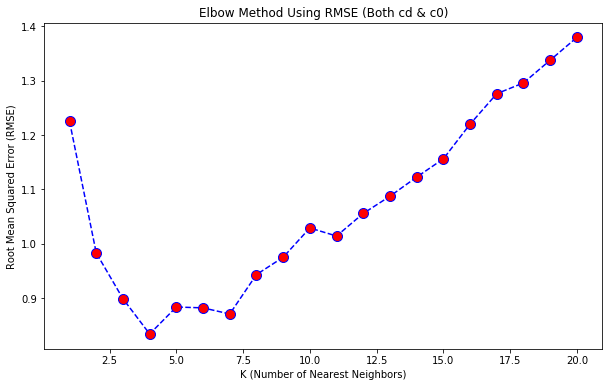

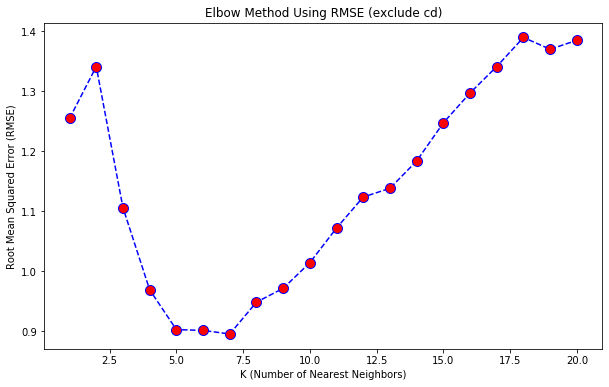

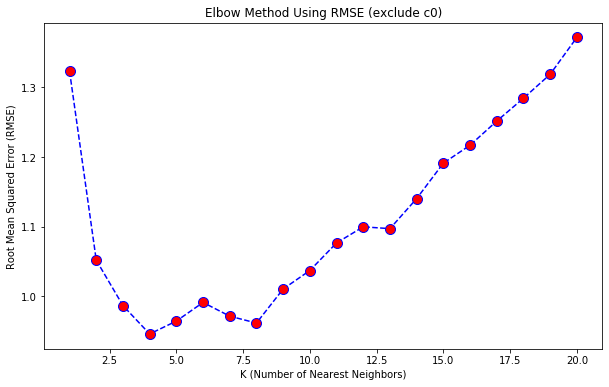

In [101]:
import matplotlib.pyplot as plt

for counter, rmse in enumerate([rmse_both, rmse_c0, rmse_cd]):
    plt.figure(figsize=(10,6))
    plt.plot(range(1,21), rmse, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.xlabel('K (Number of Nearest Neighbors)')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    if counter == 0:
        plt.title('Elbow Method Using RMSE (Both cd & c0)')
    elif counter == 1:
        plt.title('Elbow Method Using RMSE (exclude cd)')
    elif counter == 2:
        plt.title('Elbow Method Using RMSE (exclude c0)')

Including both the 'cd' and 'c0' MAC addresses that correspond to the same fixed access point in a uniformly weighted kNN-regression model, the optimal number of k-nearest neighbors appear to be 4 with the lowest RMSE of 0.83468 as shown in the elbow method plot above. The validation was tested for up to 20 nearest neighbors, but the error began to level off and begin increasing following 4 nearest neighbors.

Excluding the 'cd' MAC address and keeping 'c0', the optimal number of k-nearest neighbors appear to be 5 with a RMSE of 0.90228. Although there are lower errors for k values of 6 and 7, the elbow method suggests that that k = 5 is the elbow point of the curve where diminishing returns are no longer worth the additional costs of more nearest neighbors.

Excluding the 'c0' MAC address and keeping 'cd', the optimal number of k-nearest neighbors appear to be 4 with a RMSE of 0.94616 as shown in the elbow method plot above. In this case, the elbow point of the plot also had the lowest RMSE value. Following k = 4, the plot error begins to level and increase similarly to the elbow plot method for the validation data that includes both 'cd' and 'c0' MAC addresses that correspond to the same fixed access point.

## Distance Weighted k-NN Approach

For these clustering models, data points will be inversely weighted by their distance. The closest neighbors to new data points will have a greater influence than neighbors farther away when predicting.

In [104]:
rmse_both = []
rmse_c0 = []
rmse_cd = []

for counter, validate in enumerate(validation):
    for k in range(1,21):
        # Initialize kNN-Regressor
        knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
        # Fit model to training data
        knn.fit(validate[0], validate[2])
        # Predict
        pred = knn.predict(validate[1])
        # Store RMSE values for each K iteration
        if counter == 0:
            rmse_both.append(mean_squared_error(validate[3],pred,squared = False))
        elif counter == 1:
            rmse_c0.append(mean_squared_error(validate[3],pred, squared = False))
        elif counter == 2:
            rmse_cd.append(mean_squared_error(validate[3],pred, squared = False))

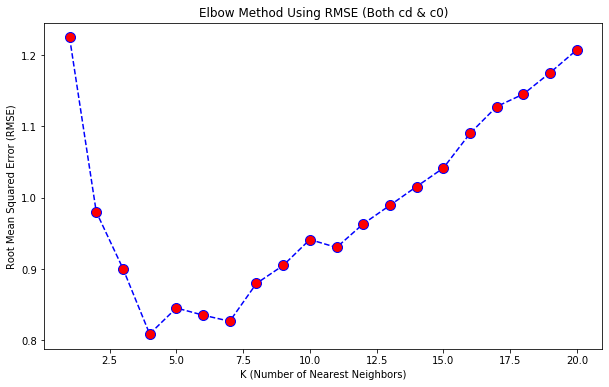

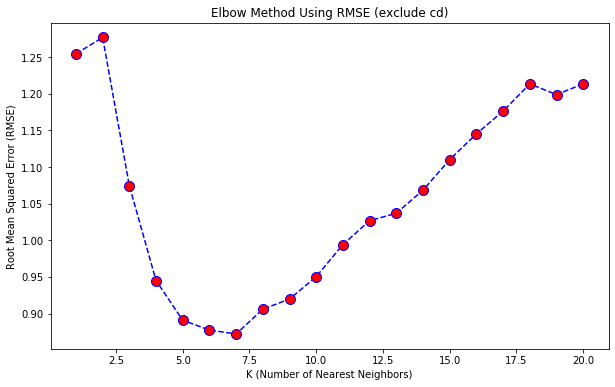

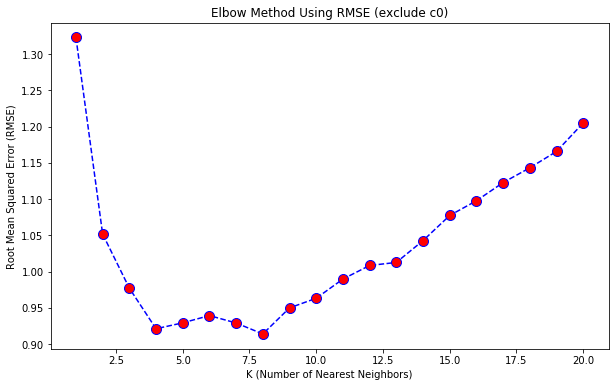

In [105]:
import matplotlib.pyplot as plt

for counter, rmse in enumerate([rmse_both, rmse_c0, rmse_cd]):
    plt.figure(figsize=(10,6))
    plt.plot(range(1,21), rmse, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.xlabel('K (Number of Nearest Neighbors)')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    if counter == 0:
        plt.title('Elbow Method Using RMSE (Both cd & c0)')
    elif counter == 1:
        plt.title('Elbow Method Using RMSE (exclude cd)')
    elif counter == 2:
        plt.title('Elbow Method Using RMSE (exclude c0)')

Including both the 'cd' and 'c0' MAC addresses that correspond to the same fixed access point in a distance weighted kNN-regression model, the optimal number of k-nearest neighbors is also 4, but has a lower RMSE of 0.80910 compared to the uniformly weighted scenario. The validation was tested for up to 20 nearest neighbors, but the error began to level off and begin increasing following k = 4 nearest neighbors. 

Excluding the 'cd' MAC address and keeping 'c0' in the distance weighted kNN-regression model, the optimal number of k-nearest neighbors is also 5, but with a lower RMSE of 0.89079 compared to the uniformly weighted scenario. Although there are lower errors for k values of 6 and 7, the elbow method suggests that that k = 5 is the elbow point of the curve where diminishing returns are no longer worth the additional costs of more nearest neighbors.

Excluding the 'c0' MAC address and keeping 'cd' in the distance weighted kNN-regression model, the optimal number of k-nearest neighbors is also 4, but with a lower RMSE of 0.92116 compared to the uniformly weighted scenario. In this case, the elbow point of the plot also had the lowest RMSE value. Following k = 4, the plot error begins to level and increase similarly to the elbow plot method for the validation data that includes both 'cd' and 'c0' MAC addresses that correspond to the same fixed access point.

In summary, the elbow plot methods for the distance weighted kNN-regressor suggested the same number of nearest neighbors for each of the 3 different scenarios as the uniformly weighted kNN-regression. However, the RMSE values in each of the 3 situations were lower for the distanced-weighted method in comparison to the unifromly-weighted method. This indicates that the using inversely weighted differences when clustering with a kNN approach for this data provides better results, which makes sense because recorded signal strengths in a laboratory setting decrease linearly with log distance.

### Separate Position Labels from Signal Strengths in Offline & Online datasets

In [127]:
# Train on Reference (offline) Data
X_both_train = offline[['00:0f:a3:39:dd:cd','00:0f:a3:39:e1:c0','00:14:bf:3b:c7:c6','00:14:bf:b1:97:81','00:14:bf:b1:97:8a','00:14:bf:b1:97:8d','00:14:bf:b1:97:90']]
X_c0_train = offline[['00:0f:a3:39:e1:c0','00:14:bf:3b:c7:c6','00:14:bf:b1:97:81','00:14:bf:b1:97:8a','00:14:bf:b1:97:8d','00:14:bf:b1:97:90']]
X_cd_train = offline[['00:0f:a3:39:dd:cd','00:14:bf:3b:c7:c6','00:14:bf:b1:97:81','00:14:bf:b1:97:8a','00:14:bf:b1:97:8d','00:14:bf:b1:97:90']]
y_train = offline[['posX','posY']]

# Test on Online Data
X_both_test = online[['00:0f:a3:39:dd:cd','00:0f:a3:39:e1:c0','00:14:bf:3b:c7:c6','00:14:bf:b1:97:81','00:14:bf:b1:97:8a','00:14:bf:b1:97:8d','00:14:bf:b1:97:90']]
X_c0_test = online[['00:0f:a3:39:e1:c0','00:14:bf:3b:c7:c6','00:14:bf:b1:97:81','00:14:bf:b1:97:8a','00:14:bf:b1:97:8d','00:14:bf:b1:97:90']]
X_cd_test = online[['00:0f:a3:39:dd:cd','00:14:bf:3b:c7:c6','00:14:bf:b1:97:81','00:14:bf:b1:97:8a','00:14:bf:b1:97:8d','00:14:bf:b1:97:90']]
y_test = online[['posX','posY']]

## Uniformly Weighted k-NN Predictions on Online Data

In [133]:
# Both 'c0' and 'cd' MAC addresses
uknn_both = KNeighborsRegressor(n_neighbors=4, weights='uniform')
uknn_both.fit(X_both_train, y_train)
upred_both = uknn_both.predict(X_both_test)
uerror_both = mean_squared_error(y_test, upred_both, squared = False)
# 'c0' MAC address
uknn_c0 = KNeighborsRegressor(n_neighbors=5, weights='uniform')
uknn_c0.fit(X_c0_train, y_train)
upred_c0 = uknn_c0.predict(X_c0_test)
uerror_c0 = mean_squared_error(y_test, upred_c0, squared = False)
# 'cd' MAC address
uknn_cd = KNeighborsRegressor(n_neighbors=4, weights='uniform')
uknn_cd.fit(X_cd_train, y_train)
upred_cd = uknn_cd.predict(X_cd_test)
uerror_cd = mean_squared_error(y_test, upred_cd, squared =False)

print('Uniformly Weighted k-NN Root Mean Squre Error (Both c0 & cd): {}'.format(uerror_both))
print('Uniformly Weighted k-NN Root Mean Squre Error (c0): {}'.format(uerror_c0))
print('Uniformly Weighted k-NN Root Mean Squre Error (cd): {}'.format(uerror_cd))

Uniformly Weighted k-NN Root Mean Squre Error (Both c0 & cd): 1.4865656729522718
Uniformly Weighted k-NN Root Mean Squre Error (c0): 1.8144243807151093
Uniformly Weighted k-NN Root Mean Squre Error (cd): 1.6170840526495114


## Distanced Weighted k-NN Predictions on Online Data

In [134]:
# Both 'c0' and 'cd' MAC addresses
dknn_both = KNeighborsRegressor(n_neighbors=4, weights='distance')
dknn_both.fit(X_both_train, y_train)
dpred_both = dknn_both.predict(X_both_test)
derror_both = mean_squared_error(y_test, dpred_both, squared = False)
# 'c0' MAC address
dknn_c0 = KNeighborsRegressor(n_neighbors=5, weights='distance')
dknn_c0.fit(X_c0_train, y_train)
dpred_c0 = dknn_c0.predict(X_c0_test)
derror_c0 = mean_squared_error(y_test, dpred_c0, squared = False)
# 'cd' MAC address
dknn_cd = KNeighborsRegressor(n_neighbors=4, weights='distance')
dknn_cd.fit(X_cd_train, y_train)
dpred_cd = dknn_cd.predict(X_cd_test)
derror_cd = mean_squared_error(y_test, dpred_cd, squared =False)

print('Inversely Weighted Distance k-NN Root Mean Squre Error (Both c0 & cd): {}'.format(derror_both))
print('Inversely Weighted Distance k-NN Root Mean Squre Error (c0): {}'.format(derror_c0))
print('Inversely Weighted Distance k-NN Root Mean Squre Error (cd): {}'.format(derror_cd))

Inversely Weighted Distance k-NN Root Mean Squre Error (Both c0 & cd): 1.489817912147946
Inversely Weighted Distance k-NN Root Mean Squre Error (c0): 1.8048570317128245
Inversely Weighted Distance k-NN Root Mean Squre Error (cd): 1.6187315417691688


## Model Performance Comparison

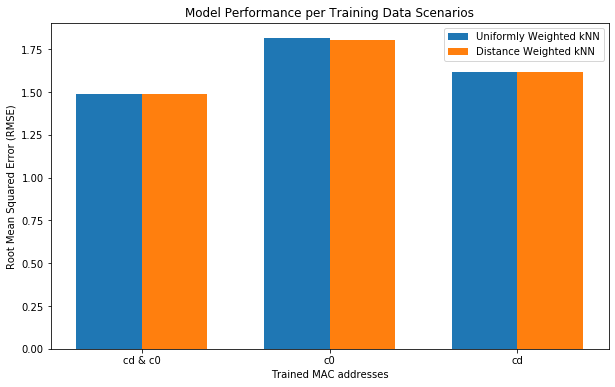

In [135]:
labels = ['cd & c0', 'c0', 'cd']
index = np.arange(len(labels))
width = 0.35
u_rmse = [uerror_both, uerror_c0, uerror_cd]
d_rmse = [derror_both, derror_c0, derror_cd]
plt.figure(figsize = (10,6))
plt.bar(index, u_rmse, width, label='Uniformly Weighted kNN')
plt.bar(index+width, d_rmse, width, label='Distance Weighted kNN')
plt.xlabel('Trained MAC addresses')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Model Performance per Training Data Scenarios')
plt.xticks(index+width/2, labels)
plt.legend(loc='best')

Comparing the error for each model in the 3 different training scenarios, including the signal strengths from both the cd and c0 MAC addresses yields the best performance results of the three. Since the error metric is root mean squared error, a lower value indicates better performance since the residuals deviate less from the fitted model. Comparing those two MAC addresses individually, performance was better when keeping only the 00:0f:a3:39:dd:cd MAC address and excluding the 00:0f:a3:39:e1:c0 MAC address. The inclusion of 00:0f:a3:39:e1:c0 MAC address and exclusion of 00:0f:a3:39:dd:cd yielded the worst results in these 3 scenarios.

Comparing the unweighted (uniform) and weighted kNN approaches (inverse distance), the results are nearly identical as shown in the plot above. However, it is interesting to note that the the unweighted models perform marginally better for the 'cd & c0' and 'cd' MAC address training scenarios against expectation. These results do not provide strong enough evidence to infer that one approach outperforms the other since the differences are extremely small at the hundredths and thousandths decimal place. 

Despite these observed results, an inversely weighted distance kNN approach is still recommended since this experiment was conducted within a laboratory test environment in which measured signal strengths are expected to decay linearly as a function of log distance. Models trained using this data for indoor positioning systems should follow the first scenario and include both 00:0f:a3:39:e1:c0 and 00:0f:a3:39:dd:cd MAC addresses for best results.

Text(0.5, 1.0, 'Actual Test Positions vs. Estimated Positions [Online Data]')

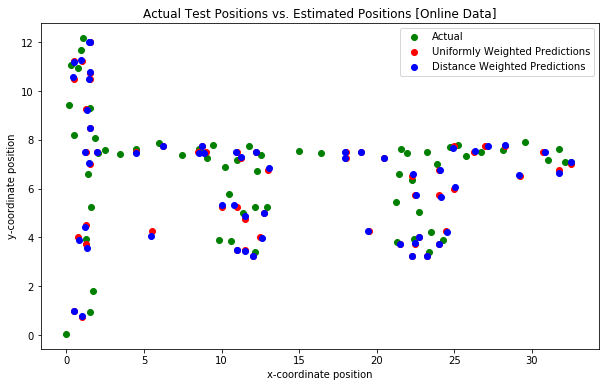

In [124]:
plt.figure(figsize = (10,6))
plt.scatter(online['posX'],online['posY'], c = 'green', label = 'Actual')
plt.scatter(upred_both[:,0],upred_both[:,1], c ='red', label = 'Uniformly Weighted Predictions')
plt.scatter(dpred_both[:,0],dpred_both[:,1], c ='blue', label = 'Distance Weighted Predictions')
plt.legend()
plt.xlabel('x-coordinate position')
plt.ylabel('y-coordinate position')
plt.title('Actual Test Positions vs. Estimated Positions [Online Data]')

The actual positions of measured signal strengths from the online data are plotted along with the estimated predictions from the uniformly weighted and distance weighted kNN regression models for comparison. The selected training subset for these predictions was the scenario including both cd & c0 mac addresses since it yielded the best performance results. As the plot shows, the predicted values largely overlap one another and are within close proximity to the actual positions in the online data. However, there are a few predictions that appear farther away from the actual positions. Notably the points positioned approximately at the [(5,4),(19,4),(17,7),(28,6)] x-y coordinate positions. Additional analysis on the larger errors around these predictions could help improve the performance of this model.